# Section A: RNN Base Model

## A: Step 1: import libraries 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import numpy as np
import nltk
import requests
from itertools import chain

## A: Step 2: Prepare the corpus

In [2]:
import requests
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import random
from collections import Counter

In [3]:
# Download necessary NLTK resources
nltk.download('punkt') 

url = "https://www.gutenberg.org/cache/epub/100/pg100.txt"

# Prepare the dataset
response = requests.get(url)
raw_text = response.text

# Define markers
start_marker = "*** START OF THE PROJECT GUTENBERG EBOOK THE COMPLETE WORKS OF WILLIAM SHAKESPEARE ***"
end_marker = "*** END OF THE PROJECT GUTENBERG EBOOK THE COMPLETE WORKS OF WILLIAM SHAKESPEARE ***"

# Find the start and end positions
start_idx = raw_text.find(start_marker) + len(start_marker)
end_idx = raw_text.find(end_marker)

# Slice out the actual content
text = raw_text[start_idx:end_idx].strip()

[nltk_data] Downloading package punkt to /Users/xiaoxuan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
#---For checking---
print(f"Extracted text length: {len(text)} characters")
print("Preview:\n", text[:1000])  # Show first 1000 characters
### End of checking

Extracted text length: 5555356 characters
Preview:
 The Complete Works of William Shakespeare

by William Shakespeare




                    Contents

    THE SONNETS
    ALL’S WELL THAT ENDS WELL
    THE TRAGEDY OF ANTONY AND CLEOPATRA
    AS YOU LIKE IT
    THE COMEDY OF ERRORS
    THE TRAGEDY OF CORIOLANUS
    CYMBELINE
    THE TRAGEDY OF HAMLET, PRINCE OF DENMARK
    THE FIRST PART OF KING HENRY THE FOURTH
    THE SECOND PART OF KING HENRY THE FOURTH
    THE LIFE OF KING HENRY THE FIFTH
    THE FIRST PART OF HENRY THE SIXTH
    THE SECOND PART OF KING HENRY THE SIXTH
    THE THIRD PART OF KING HENRY THE SIXTH
    KING HENRY THE EIGHTH
    THE LIFE AND DEATH OF KING JOHN
    THE TRAGEDY OF JULIUS CAESAR
    THE TRAGEDY OF KING LEAR
    LOVE’S LABOUR’S LOST
    THE TRAGEDY OF MACBETH
    MEASURE FOR MEASURE
    THE MERCHANT OF VENICE
    THE MERRY WIVES OF WINDSOR
    A MIDSUMMER NIGHT’S DREAM
    MUCH ADO ABOUT NOTHING
    THE TRAGEDY OF OTHELLO, THE MOOR OF VENICE
    PERICLES, PR

In [5]:
# Tokenize text into sentences, then words
sentences = sent_tokenize(text)
tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in sentences]
tokenized_sentences = [  # Remove punctuation and numbers to keep alphabetic words only
    [word for word in sentence if word.isalpha() and len(word) > 1]  # Also remove single letters
    for sentence in tokenized_sentences
]

total_words = sum(len(sentence) for sentence in tokenized_sentences)
print(f"Total sentences: {len(tokenized_sentences)}") #104698
print(f"Total words: {total_words}") #911436

# Check first 5 sentences
print("\nFirst 5 tokenized sentences:")
for i, sentence in enumerate(tokenized_sentences[:5]):
    print(f"{i+1}: {' '.join(sentence)}")

Total sentences: 104698
Total words: 911436

First 5 tokenized sentences:
1: the complete works of william shakespeare by william shakespeare contents the sonnets all well that ends well the tragedy of antony and cleopatra as you like it the comedy of errors the tragedy of coriolanus cymbeline the tragedy of hamlet prince of denmark the first part of king henry the fourth the second part of king henry the fourth the life of king henry the fifth the first part of henry the sixth the second part of king henry the sixth the third part of king henry the sixth king henry the eighth the life and death of king john the tragedy of julius caesar the tragedy of king lear love labour lost the tragedy of macbeth measure for measure the merchant of venice the merry wives of windsor midsummer night dream much ado about nothing the tragedy of othello the moor of venice pericles prince of tyre king richard the second king richard the third the tragedy of romeo and juliet the taming of the shrew the te

In [6]:
# Split the Gutenberg text into train/val/test: 80/10/10
random.seed(42)
random.shuffle(tokenized_sentences)  # Shuffle sentences for better distribution

total_sentences = len(tokenized_sentences)
train_size = int(total_sentences * 0.8)
remaining = total_sentences - train_size

# Split remaining evenly between val and test
val_size = remaining // 2
test_size = remaining - val_size


# Split the data
train_data_sentences = tokenized_sentences[:train_size]
val_data_sentences = tokenized_sentences[train_size:train_size + val_size]
test_data_sentences = tokenized_sentences[train_size + val_size:]

print(f"\nDataset split:")
print(f"Train sentences: {len(train_data_sentences)}") #Train sentences: 83758
print(f"Val sentences: {len(val_data_sentences)}") #Val sentences: 10470
print(f"Test sentences: {len(test_data_sentences)}") #Test sentences: 10470


Dataset split:
Train sentences: 83758
Val sentences: 10470
Test sentences: 10470


In [7]:
# Build vocabulary from training data only
counter = Counter(token for sentence in train_data_sentences for token in sentence)
print(f"Unique words in training data: {len(counter)}") #Unique words in training data: 22006

vocab = {word: idx for idx, (word, _) in enumerate(counter.most_common(), start=4)}
vocab.update({"<unk>": 0, "<pad>": 1, "<bos>": 2, "<eos>": 3})

# Create inverse vocabulary mapping
inv_vocab = {idx: word for word, idx in vocab.items()}

#print(f"Final vocabulary size: {len(vocab)}") #Final vocabulary size: 22006

Unique words in training data: 22006


In [8]:
# Numericalize data: Convert words to IDs
def numericalize(data, vocab):
    numericalized = []
    for sentence in data:
        # Add <bos> at start and <eos> at end
        numericalized.append([vocab["<bos>"]] + [vocab.get(word, vocab["<unk>"]) for word in sentence] + [vocab["<eos>"]])
    return numericalized

# Convert all splits to numerical format
train_data = numericalize(train_data_sentences, vocab)
val_data = numericalize(val_data_sentences, vocab)
test_data = numericalize(test_data_sentences, vocab)

In [9]:
#---For checking---  

# Check the numericalized data
print(f"\nNumericalized data sample:")
print(f"Original sentence: {' '.join(train_data_sentences[0])}")
print(f"Numericalized: {train_data[0][:10]}...")  # Show first 10 tokens

# Check average sentence lengths
train_lengths = [len(sentence) for sentence in train_data]
val_lengths = [len(sentence) for sentence in val_data]
test_lengths = [len(sentence) for sentence in test_data]

# Print some Dataset statistics
print(f"\nAverage sentence lengths:")
print(f"Train: {sum(train_lengths)/len(train_lengths):.1f} tokens") #10.7 tokens
print(f"Val: {sum(val_lengths)/len(val_lengths):.1f} tokens") #10.8 tokens
print(f"Test: {sum(test_lengths)/len(test_lengths):.1f} tokens") #10.6 tokens
print(f"- Total vocabulary size: {len(vocab):,}") #Total vocabulary size: 22,047
print(f"- Training sentences: {len(train_data):,}") #Training sentences: 83,758
print(f"- Validation sentences: {len(val_data):,}") #Validation sentences: 10,470
print(f"- Test sentences: {len(test_data):,}") #Test sentences: 10,470
print(f"- Total training tokens: {sum(len(s) for s in train_data):,}") #Total training tokens: 896,922
print(f"- Total validation tokens: {sum(len(s) for s in val_data):,}") #Total validation tokens: 112,644
print(f"- Total test tokens: {sum(len(s) for s in test_data):,}") #Total test tokens: 111,266


Numericalized data sample:
Original sentence: that were to blow at fire in hope to quench it for who digs hills because they do aspire throws down one mountain to cast up higher
Numericalized: [2, 11, 87, 6, 1026, 51, 383, 10, 292, 6]...

Average sentence lengths:
Train: 10.7 tokens
Val: 10.8 tokens
Test: 10.6 tokens
- Total vocabulary size: 22,010
- Training sentences: 83,758
- Validation sentences: 10,470
- Test sentences: 10,470
- Total training tokens: 896,922
- Total validation tokens: 112,644
- Total test tokens: 111,266


In [10]:
# Show most common words
print("\nTop 10 most common words:")
for word, count in counter.most_common(10):
    print(f"{word}: {count}")
#ANS: the, and, to, of, you, my, in, that, is, not


Top 10 most common words:
the: 24295
and: 22729
to: 16670
of: 14868
you: 11736
my: 10506
in: 9972
that: 9792
not: 7918
is: 7914


## A: Step 3: Define Dataset and DataLoader

In [11]:
class ShakespeareDataset(Dataset):
    def __init__(self, data, seq_len):
        self.samples = []
        self.seq_len = seq_len

        # Build list of all valid subsequences
        for sentence in data:
            if len(sentence) > seq_len:  # only use long enough sentences
                for i in range(len(sentence) - seq_len):
                    x = sentence[i:i + seq_len]
                    y = sentence[i + 1:i + seq_len + 1]
                    self.samples.append((x, y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)
    

In [12]:
# Hyperparameters
seq_len = 128

# Create datasets
train_dataset = ShakespeareDataset(train_data, seq_len)
val_dataset = ShakespeareDataset(val_data, seq_len)
test_dataset = ShakespeareDataset(test_data, seq_len)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
#DataLoader: Automatically batches and shuffles data for training.

## A: Step 4: Build the RNN Model

In [13]:
class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, pad_idx, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=pad_idx)
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        embedded = self.embedding(x)  # Shape: (batch_size, seq_len, embed_size)
        output, hidden = self.rnn(embedded, hidden)  # RNN output and hidden state
        output = self.dropout(output) # Apply dropout
        output = self.fc(output)  # Shape: (batch_size, seq_len, vocab_size)
        return output, hidden

## A: Step 5: Train the Model

In [14]:
import numpy as np
# Model hyperparameters
vocab_size = len(vocab)
embed_size = 128
hidden_size = 256
num_layers = 1

model = RNNLanguageModel(vocab_size, embed_size, hidden_size, num_layers, pad_idx=vocab["<pad>"])
criterion = nn.CrossEntropyLoss(ignore_index=vocab["<pad>"])
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=1)

In [15]:
# ----- Tracking -----
train_losses, train_PPL, val_losses, val_PPL = [], [], [], []

def clip_gradients(model, max_norm=1.0):
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

# Training loop
num_epochs = 5
grad_accum_steps = 4
import time

In [39]:
start_time = time.time()
for epoch in range(num_epochs):
    ## ----- Training ----- 
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for step, (x, y) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        output, _ = model(x)
        loss = criterion(output.view(-1, vocab_size), y.view(-1))
        loss = loss / grad_accum_steps
        loss.backward()

        if (step + 1) % grad_accum_steps == 0:
            clip_gradients(model, max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item() * grad_accum_steps

    avg_train_loss = total_loss / len(train_loader)
    train_perplexity = np.exp(avg_train_loss)
    train_losses.append(avg_train_loss)
    train_PPL.append(train_perplexity)

    ## ----- Validation -----
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:   # no tqdm here
            output, _ = model(x)
            loss = criterion(output.view(-1, vocab_size), y.view(-1))
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_perplexity = np.exp(avg_val_loss)
    val_losses.append(avg_val_loss)
    val_PPL.append(val_perplexity)

    scheduler.step(avg_val_loss)

    ## ----- Logs -----
    print(f"Epoch {epoch+1} | "
          f"Train Loss: {avg_train_loss:.4f} | Train PPL: {train_perplexity:.2f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val PPL: {val_perplexity:.2f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")

# ----- End time -----
end_time = time.time()
print(f"Total training time: {(end_time - start_time)/60:.2f} minutes")

Training Epoch 1: 100%|█████████████████████████| 23/23 [00:16<00:00,  1.41it/s]


Epoch 1 | Train Loss: 9.7317 | Train PPL: 16842.77 | Val Loss: 9.7685 | Val PPL: 17475.07 | LR: 0.001000


Training Epoch 2: 100%|█████████████████████████| 23/23 [00:16<00:00,  1.43it/s]


Epoch 2 | Train Loss: 8.5786 | Train PPL: 5316.69 | Val Loss: 8.5560 | Val PPL: 5197.68 | LR: 0.001000


Training Epoch 3: 100%|█████████████████████████| 23/23 [00:15<00:00,  1.53it/s]


Epoch 3 | Train Loss: 7.0812 | Train PPL: 1189.35 | Val Loss: 7.9965 | Val PPL: 2970.53 | LR: 0.001000


Training Epoch 4: 100%|█████████████████████████| 23/23 [00:13<00:00,  1.67it/s]


Epoch 4 | Train Loss: 6.3438 | Train PPL: 568.96 | Val Loss: 7.9094 | Val PPL: 2722.79 | LR: 0.001000


Training Epoch 5: 100%|█████████████████████████| 23/23 [00:13<00:00,  1.69it/s]


Epoch 5 | Train Loss: 6.0156 | Train PPL: 409.79 | Val Loss: 7.8840 | Val PPL: 2654.38 | LR: 0.001000
Total training time: 1.33 minutes


In [40]:
# Create a dataframe for all values
import pandas as pd
data = {
    "Train Loss": train_losses,
    "Train PPL": train_PPL,
    "Val Loss": val_losses,
    "Val PPL": val_PPL
}
# Build DataFrame
df = pd.DataFrame(data, index=[f"Epoch {i+1}" for i in range(num_epochs)])


# Add final row for training time
training_time_minutes = (end_time - start_time) / 60
df.loc[num_epochs] = [f"---", f"---", f"---", f"Time: {training_time_minutes:.2f} min"]

# Show table
print(df)

        Train Loss     Train PPL  Val Loss         Val PPL
Epoch 1   9.731677  16842.774914  9.768531    17475.074768
Epoch 2   8.578605   5316.685609  8.555968     5197.680318
Epoch 3   7.081158   1189.345125  7.996496     2970.532151
Epoch 4   6.343818    568.964583  7.909414     2722.794196
Epoch 5   6.015643    409.789153  7.883965     2654.377378
5              ---           ---       ---  Time: 1.33 min


## A: Step 6: Plot training and validation loss curves

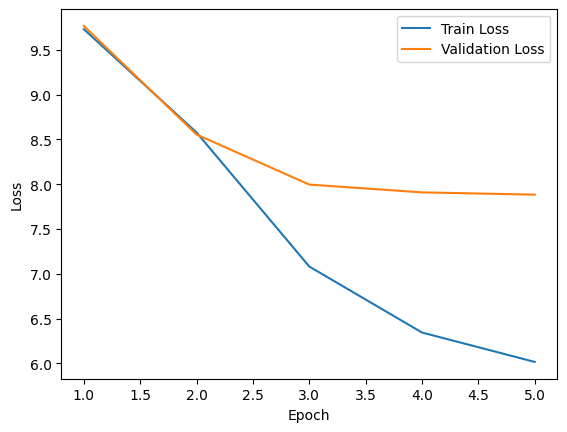

In [41]:
import matplotlib.pyplot as plt

epochs = [i + 1 for i in range(len(train_losses))]  # start from 1 instead of 0

plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

We can see that both curves are having a decreasing trend, where train loss has a faster decreasing rate than validation loss.

## A: Step 7: Evaluate the Model

In [42]:
def cross_entropy_loss_and_perplexity(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x,y in data_loader:
            output, _ =model(x)
            loss = criterion(output.view(-1, vocab_size), y.view(-1))
            total_loss += loss.item()
    avg_loss =  total_loss/ len(data_loader)
    perplexity = np.exp(avg_loss)
    return avg_loss, perplexity

### Evaluation

In [43]:
val_loss, val_PPL = cross_entropy_loss_and_perplexity(model, val_loader)
test_loss, test_PPL = cross_entropy_loss_and_perplexity(model, test_loader)
print(f"Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}")
print(f"Val Perplexity: {val_PPL:.4f}, Test Perplexity: {test_PPL:.4f}")

Val Loss: 7.8840, Test Loss: 8.9502
Val Perplexity: 2654.3774, Test Perplexity: 7709.3386


Generalisation Ratio = 2654.3774/7709.3386 = 0.344

This huge gap between validation and test perplexity strongly shows that the model is not generalising well to unseen data, as the model will probably seen the validation data already.

## A: Step 8: Generate Text 

In [44]:
def generate_text(model, start_seq, max_len=1000, temperature=1.0, max_words=None, top_k=None):
    model.eval()
    idx_seq = [vocab.get(word, vocab["<unk>"]) for word in start_seq]
    x = torch.tensor([idx_seq], dtype=torch.long)
    hidden = None
    result = start_seq.copy()

    for _ in range(max_len):
        output, hidden = model(x, hidden)
        logits = output[:, -1, :] / temperature

        # ---- Top-k filtering ----
        if top_k is not None:
            topk_logits, topk_indices = torch.topk(logits, top_k)
            probs = torch.softmax(topk_logits, dim=-1)
            next_token = topk_indices[torch.multinomial(probs, num_samples=1)].item()
        else:
            # Standard multinomial sampling (full vocab)
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1).item()
        # -------------------------

        # Only if want early stopping at <eos>
        # if next_token == vocab["<eos>"]:
        #     break

        result.append(inv_vocab[next_token])
        if max_words is not None and len(result) >= max_words:
            break

        x = torch.tensor([[next_token]], dtype=torch.long)

    return " ".join(result)

In [45]:
for T in [0.7, 1.0, 1.3]:
    print(f"[Sampling with T={T}] ")
    print(generate_text(model, ["the"], max_len=1000, max_words=150, temperature=T))

[Sampling with T=0.7] 
the tragedy of king the merchant general king passionate his lucrece his kings to the king injuries the cressida to and in the winter the second the life to this the of to your of of these of on the fourth of his to the world the merry of the second of king of herald of the cuckoo this the seeming pilgrim of king of kinsmen the son the first king his that adonis the lover dost even never the passionate of the king of rape and of taming of elizabeth of john earl the that the of to sight should king the the so of pilgrim of the winter of coriolanus near the venice george beauty that the epilogue the world of fortune his for and the king of not of his the tragedy of the scribes the air of with know the he the that the much of
[Sampling with T=1.0] 
the philo loan turtle of thine irish the with the useth buckingham measure in fairy john earl answer night and of set for third the katherine to usage life henry pompey of man immodest or in at pirithous took from thomas 

# Section B: Ablation Study on Dropout = 0.0

## Steps 1 - 3 are the same as above
## B: Step 4: Build the RNN Model

In [13]:
class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, pad_idx, dropout = 0.0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=pad_idx)
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        embedded = self.embedding(x)  # Shape: (batch_size, seq_len, embed_size)
        output, hidden = self.rnn(embedded, hidden)  # RNN output and hidden state
        output = self.dropout(output) # Apply dropout
        output = self.fc(output)  # Shape: (batch_size, seq_len, vocab_size)
        return output, hidden

## B: Step 5: Train the Model

In [14]:
import numpy as np
# Model hyperparameters
vocab_size = len(vocab)
embed_size = 128
hidden_size = 256
num_layers = 1

model = RNNLanguageModel(vocab_size, embed_size, hidden_size, num_layers, pad_idx=vocab["<pad>"])
criterion = nn.CrossEntropyLoss(ignore_index=vocab["<pad>"])
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=1)

In [15]:
# ----- Tracking -----
train_losses, train_PPL, val_losses, val_PPL = [], [], [], []

def clip_gradients(model, max_norm=1.0):
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

# Training loop
num_epochs = 5
grad_accum_steps = 4
import time

In [16]:
start_time = time.time()
for epoch in range(num_epochs):
    ## ----- Training ----- 
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for step, (x, y) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        output, _ = model(x)
        loss = criterion(output.view(-1, vocab_size), y.view(-1))
        loss = loss / grad_accum_steps
        loss.backward()

        if (step + 1) % grad_accum_steps == 0:
            clip_gradients(model, max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item() * grad_accum_steps

    avg_train_loss = total_loss / len(train_loader)
    train_perplexity = np.exp(avg_train_loss)
    train_losses.append(avg_train_loss)
    train_PPL.append(train_perplexity)

    ## ----- Validation -----
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:   # no tqdm here
            output, _ = model(x)
            loss = criterion(output.view(-1, vocab_size), y.view(-1))
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_perplexity = np.exp(avg_val_loss)
    val_losses.append(avg_val_loss)
    val_PPL.append(val_perplexity)

    scheduler.step(avg_val_loss)

    ## ----- Logs -----
    print(f"Epoch {epoch+1} | "
          f"Train Loss: {avg_train_loss:.4f} | Train PPL: {train_perplexity:.2f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val PPL: {val_perplexity:.2f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")

# ----- End time -----
end_time = time.time()
print(f"Total training time: {(end_time - start_time)/60:.2f} minutes")

Training Epoch 1: 100%|█████████████████████████| 23/23 [00:16<00:00,  1.41it/s]


Epoch 1 | Train Loss: 9.7103 | Train PPL: 16486.16 | Val Loss: 9.7473 | Val PPL: 17108.61 | LR: 0.001000


Training Epoch 2: 100%|█████████████████████████| 23/23 [00:14<00:00,  1.58it/s]


Epoch 2 | Train Loss: 8.4500 | Train PPL: 4674.87 | Val Loss: 8.4588 | Val PPL: 4716.25 | LR: 0.001000


Training Epoch 3: 100%|█████████████████████████| 23/23 [00:16<00:00,  1.41it/s]


Epoch 3 | Train Loss: 6.9710 | Train PPL: 1065.27 | Val Loss: 8.0014 | Val PPL: 2985.02 | LR: 0.001000


Training Epoch 4: 100%|█████████████████████████| 23/23 [00:15<00:00,  1.49it/s]


Epoch 4 | Train Loss: 6.2812 | Train PPL: 534.40 | Val Loss: 7.9925 | Val PPL: 2958.83 | LR: 0.001000


Training Epoch 5: 100%|█████████████████████████| 23/23 [00:15<00:00,  1.51it/s]


Epoch 5 | Train Loss: 5.9060 | Train PPL: 367.24 | Val Loss: 8.0910 | Val PPL: 3265.01 | LR: 0.001000
Total training time: 1.38 minutes


In [17]:
# Create a dataframe for all values
import pandas as pd
data = {
    "Train Loss": train_losses,
    "Train PPL": train_PPL,
    "Val Loss": val_losses,
    "Val PPL": val_PPL
}
# Build DataFrame
df = pd.DataFrame(data, index=[f"Epoch {i+1}" for i in range(num_epochs)])


# Add final row for training time
training_time_minutes = (end_time - start_time) / 60
df.loc[num_epochs] = [f"---", f"---", f"---", f"Time: {training_time_minutes:.2f} min"]

# Show table
print(df)


        Train Loss     Train PPL  Val Loss         Val PPL
Epoch 1   9.710277  16486.160696  9.747337    17108.613709
Epoch 2   8.449957   4674.870925  8.458769     4716.246638
Epoch 3    6.97098   1065.266025  8.001361     2985.016376
Epoch 4   6.281153    534.404297  7.992548     2958.826138
Epoch 5   5.906004    367.235705  8.091018     3265.008755
5              ---           ---       ---  Time: 1.38 min


This shows a massive improvement and indicates that with less regularisation, the model is able to learn the training patterns more effectively, which also helped its performance on the validation set.

## B: Step 6: Plot training and validation loss curves

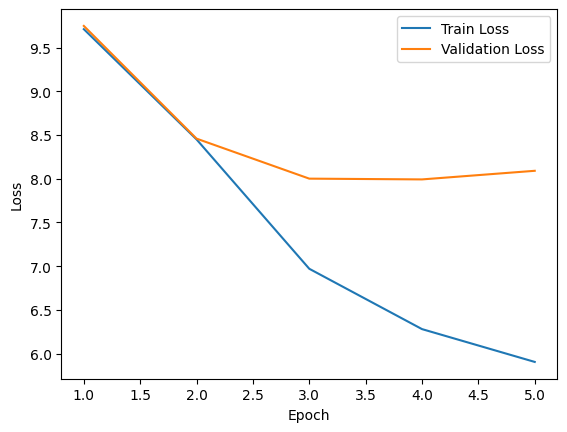

In [18]:
import matplotlib.pyplot as plt

epochs = [i + 1 for i in range(len(train_losses))]  # start from 1 instead of 0

plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

We can see that both curves are having a decreasing trend, where train loss has a faster decreasing rate than validation loss, while validation loss has a slight increase from epoch 3 onwards. 

## B: Step 7: Evaluate the Model

In [19]:
def cross_entropy_loss_and_perplexity(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x,y in data_loader:
            output, _ =model(x)
            loss = criterion(output.view(-1, vocab_size), y.view(-1))
            total_loss += loss.item()
    avg_loss =  total_loss/ len(data_loader)
    perplexity = np.exp(avg_loss)
    return avg_loss, perplexity

### Evaluation

In [20]:
val_loss, val_PPL = cross_entropy_loss_and_perplexity(model, val_loader)
test_loss, test_PPL = cross_entropy_loss_and_perplexity(model, test_loader)
print(f"Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}")
print(f"Val Perplexity: {val_PPL:.4f}, Test Perplexity: {test_PPL:.4f}")

Val Loss: 8.0910, Test Loss: 9.2182
Val Perplexity: 3265.0088, Test Perplexity: 10078.6629


Generalisation Ratio = 3265.0088/10078.6629 = 0.324

While no dropout rate helps the model fit the training data better, it also makes the model far more susceptible to overfitting. 

The improved performance on the validation set was misleading because the model was ultimately not learning a robust, generalisable representation. It was likely "memorising" specific patterns of the training and validation data, which then failed on the new test data.

Overall, the RNN base model performed better than this ablation study of dropout 0.0 instead of 0.3, as the generalisation ratio is slightly closer to 1 than this model (original: 0.344, ablation: 0.324), and the validation and test perplexity (2,654.37 to 3,265.01 and 7,709.34 to 10,078.66, respectively) performed worse than the RNN base model.

## B: Step 8: Generate Text 

In [21]:
def generate_text(model, start_seq, max_len=1000, temperature=1.0, max_words=None, top_k=None):
    model.eval()
    idx_seq = [vocab.get(word, vocab["<unk>"]) for word in start_seq]
    x = torch.tensor([idx_seq], dtype=torch.long)
    hidden = None
    result = start_seq.copy()

    for _ in range(max_len):
        output, hidden = model(x, hidden)
        logits = output[:, -1, :] / temperature

        # ---- Top-k filtering ----
        if top_k is not None:
            topk_logits, topk_indices = torch.topk(logits, top_k)
            probs = torch.softmax(topk_logits, dim=-1)
            next_token = topk_indices[torch.multinomial(probs, num_samples=1)].item()
        else:
            # Standard multinomial sampling (full vocab)
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1).item()
        # -------------------------

        # Only if want early stopping at <eos>
        # if next_token == vocab["<eos>"]:
        #     break

        result.append(inv_vocab[next_token])
        if max_words is not None and len(result) >= max_words:
            break

        x = torch.tensor([[next_token]], dtype=torch.long)

    return " ".join(result)

In [22]:
for T in [0.7, 1.0, 1.3]:
    print(f"[Sampling with T={T}] ")
    print(generate_text(model, ["the"], max_len=1000, max_words=150, temperature=T))

[Sampling with T=0.7] 
the emperor the eighth of the and the of forth and and in of and his limbs the of oath of the with the gentlemen of king of self the wind sight of and with night servant with of and the tragedy of the athens which of of of and this of herald of the the othello of his of time king of night the might tragedy his as phoenix adonis congreeted duke of of afterwards the sufferances of the the the tragedy of the duke of this you to far of the turtle of with of night this sixth the so and chapeless the tragedy of freshes that lord so and of the who grave the tragedy of the of this the the sir of your tyre servant earl broken sir this lord the that the with the rose bishop and from of of and thy of part of
[Sampling with T=1.0] 
the winchester not night rivers thy the life to sometime lampass of rain till with after this of of the <eos> hast you dream edmund cutt the him of night have and rude night night and night macbeth the nicholas he desire render his medicine scroop

# Section C: Ablation Study on Sequence Length = 64

## C: Steps 1 - 2 are the same as above

## C: Step 3: Define Dataset and DataLoader

In [55]:
class ShakespeareDataset(Dataset):
    def __init__(self, data, seq_len):
        self.samples = []
        self.seq_len = seq_len

        # Build list of all valid subsequences
        for sentence in data:
            if len(sentence) > seq_len:  # only use long enough sentences
                for i in range(len(sentence) - seq_len):
                    x = sentence[i:i + seq_len]
                    y = sentence[i + 1:i + seq_len + 1]
                    self.samples.append((x, y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

In [56]:
# Hyperparameters
seq_len = 64

# Create datasets
train_dataset = ShakespeareDataset(train_data, seq_len)
val_dataset = ShakespeareDataset(val_data, seq_len)
test_dataset = ShakespeareDataset(test_data, seq_len)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
#DataLoader: Automatically batches and shuffles data for training.

## C: Step 4: Build the RNN Model

In [57]:
class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, pad_idx, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=pad_idx)
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        embedded = self.embedding(x)  # Shape: (batch_size, seq_len, embed_size)
        output, hidden = self.rnn(embedded, hidden)  # RNN output and hidden state
        output = self.dropout(output) # Apply dropout
        output = self.fc(output)  # Shape: (batch_size, seq_len, vocab_size)
        return output, hidden

## C: Step 5: Train the Model

In [58]:
import numpy as np
# Model hyperparameters
vocab_size = len(vocab)
embed_size = 128
hidden_size = 256
num_layers = 1

model = RNNLanguageModel(vocab_size, embed_size, hidden_size, num_layers, pad_idx=vocab["<pad>"])
criterion = nn.CrossEntropyLoss(ignore_index=vocab["<pad>"])
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=1)

In [59]:
# ----- Tracking -----
train_losses, train_PPL, val_losses, val_PPL = [], [], [], []

def clip_gradients(model, max_norm=1.0):
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

# Training loop
num_epochs = 5
grad_accum_steps = 4
import time

In [60]:
start_time = time.time()
for epoch in range(num_epochs):
    ## ----- Training ----- 
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for step, (x, y) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        output, _ = model(x)
        loss = criterion(output.view(-1, vocab_size), y.view(-1))
        loss = loss / grad_accum_steps
        loss.backward()

        if (step + 1) % grad_accum_steps == 0:
            clip_gradients(model, max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item() * grad_accum_steps

    avg_train_loss = total_loss / len(train_loader)
    train_perplexity = np.exp(avg_train_loss)
    train_losses.append(avg_train_loss)
    train_PPL.append(train_perplexity)

    ## ----- Validation -----
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:   # no tqdm here
            output, _ = model(x)
            loss = criterion(output.view(-1, vocab_size), y.view(-1))
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_perplexity = np.exp(avg_val_loss)
    val_losses.append(avg_val_loss)
    val_PPL.append(val_perplexity)

    scheduler.step(avg_val_loss)

    ## ----- Logs -----
    print(f"Epoch {epoch+1} | "
          f"Train Loss: {avg_train_loss:.4f} | Train PPL: {train_perplexity:.2f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val PPL: {val_perplexity:.2f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")

# ----- End time -----
end_time = time.time()
print(f"Total training time: {(end_time - start_time)/60:.2f} minutes")

Training Epoch 1: 100%|███████████████████████| 318/318 [01:42<00:00,  3.11it/s]


Epoch 1 | Train Loss: 7.3777 | Train PPL: 1599.92 | Val Loss: 7.5244 | Val PPL: 1852.67 | LR: 0.001000


Training Epoch 2: 100%|███████████████████████| 318/318 [01:49<00:00,  2.91it/s]


Epoch 2 | Train Loss: 6.3100 | Train PPL: 550.04 | Val Loss: 7.3900 | Val PPL: 1619.70 | LR: 0.001000


Training Epoch 3: 100%|███████████████████████| 318/318 [01:39<00:00,  3.19it/s]


Epoch 3 | Train Loss: 5.4766 | Train PPL: 239.03 | Val Loss: 7.3359 | Val PPL: 1534.48 | LR: 0.001000


Training Epoch 4: 100%|███████████████████████| 318/318 [01:51<00:00,  2.85it/s]


Epoch 4 | Train Loss: 4.5288 | Train PPL: 92.65 | Val Loss: 7.4244 | Val PPL: 1676.43 | LR: 0.001000


Training Epoch 5: 100%|███████████████████████| 318/318 [01:39<00:00,  3.18it/s]


Epoch 5 | Train Loss: 3.6494 | Train PPL: 38.45 | Val Loss: 7.5956 | Val PPL: 1989.48 | LR: 0.000500
Total training time: 9.18 minutes


In [61]:
# Create a table for all values

#import pandas as pd
data = {
    "Train Loss": train_losses,
    "Train PPL": train_PPL,
    "Val Loss": val_losses,
    "Val PPL": val_PPL
}
# Build DataFrame
df = pd.DataFrame(data, index=[f"Epoch {i+1}" for i in range(num_epochs)])


# Add final row for training time
training_time_minutes = (end_time - start_time) / 60
df.loc[num_epochs] = [f"---", f"---", f"---", f"Time: {training_time_minutes:.2f} min"]

# Show table
print(df)

        Train Loss    Train PPL  Val Loss         Val PPL
Epoch 1   7.377708  1599.918247  7.524381     1852.665936
Epoch 2   6.309999   550.044199  7.389994     1619.696744
Epoch 3   5.476591    239.03037  7.335946     1534.479071
Epoch 4   4.528828    92.649875  7.424424     1676.433956
Epoch 5    3.64941    38.451965  7.595629     1989.480422
5              ---          ---       ---  Time: 9.18 min


This shows a massive improvement and indicates that with less regularisation, the model is able to learn the training patterns more effectively, which also helped its performance on the validation set.

## C: Step 6: Plot training and validation loss curves


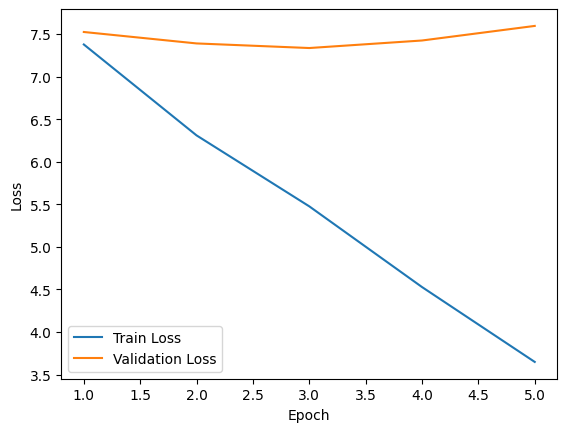

In [62]:
import matplotlib.pyplot as plt

epochs = [i + 1 for i in range(len(train_losses))]  # start from 1 instead of 0

plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

We can see that both curves are having a decreasing trend, where train loss has a faster decreasing rate than validation loss, while validation loss has a slight increase from epoch 3 onwards. 

## C: Step 7: Evaluate the Model

In [63]:
def cross_entropy_loss_and_perplexity(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x,y in data_loader:
            output, _ =model(x)
            loss = criterion(output.view(-1, vocab_size), y.view(-1))
            total_loss += loss.item()
    avg_loss =  total_loss/ len(data_loader)
    perplexity = np.exp(avg_loss)
    return avg_loss, perplexity

### Evaluation


In [64]:
val_loss, val_PPL = cross_entropy_loss_and_perplexity(model, val_loader)
test_loss, test_PPL = cross_entropy_loss_and_perplexity(model, test_loader)
print(f"Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}")
print(f"Val Perplexity: {val_PPL:.4f}, Test Perplexity: {test_PPL:.4f}")

Val Loss: 7.5956, Test Loss: 7.7011
Val Perplexity: 1989.4804, Test Perplexity: 2210.8663


Generalisation Ratio = 1989.4804/2210.8663 = 0.900

The gap between the validation perplexity and test perplexity has narrowed considerably, with a test perplexity of 2210.87. This indicates that the model is now generalising much better and not just memorising the validation set. The change in sequence length appears to have been an effective way to regularise the model and improve its performance on unseen data.

Overall, this model performed better than the RNN base model of sequence length of 128 instead of 64, as the generalisation ratio is still much closer to 1 than the RNN base model (original: 0.344, ablation: 0.900), and the validation and test perplexity (2,654.37 to 1,989.48 and 7,709.34 to 2,210.87, respectively) performed better than the RNN base model.

## C: Step 8: Generate Text

In [65]:
def generate_text(model, start_seq, max_len=1000, temperature=1.0, max_words=None, top_k=None):
    model.eval()
    idx_seq = [vocab.get(word, vocab["<unk>"]) for word in start_seq]
    x = torch.tensor([idx_seq], dtype=torch.long)
    hidden = None
    result = start_seq.copy()

    for _ in range(max_len):
        output, hidden = model(x, hidden)
        logits = output[:, -1, :] / temperature

        # ---- Top-k filtering ----
        if top_k is not None:
            topk_logits, topk_indices = torch.topk(logits, top_k)
            probs = torch.softmax(topk_logits, dim=-1)
            next_token = topk_indices[torch.multinomial(probs, num_samples=1)].item()
        else:
            # Standard multinomial sampling (full vocab)
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1).item()
        # -------------------------

        # Only if want early stopping at <eos>
        # if next_token == vocab["<eos>"]:
        #     break

        result.append(inv_vocab[next_token])
        if max_words is not None and len(result) >= max_words:
            break

        x = torch.tensor([[next_token]], dtype=torch.long)

    return " ".join(result)

In [66]:
for T in [0.7, 1.0, 1.3]:
    print(f"[Sampling with T={T}] ")
    print(generate_text(model, ["the"], max_len=1000, max_words=150, temperature=T))

[Sampling with T=0.7] 
the lineal of the world and the drowsy of the crown and make the hand of the world ransom will be one minute in the french spring in the swallowing gulf of the same that we the counterfeit of the commons excepting of love beside the sixth the second part of king henry the fourth the king of the sword of buckingham sir nicholas vaux surveyor to the king of the world that bulwark it pry through the portage of the shrew the tempest that by the capitol join gripes with broken hilt to stables and england his glory and the poor maid that it the night for every the stones of france and wit to his unnatural purpose to the pail so that he that hell to this theoric which shore it in love with jessica shylock rich jew tubal jew his haste from brassy the immaculate from heaven
[Sampling with T=1.0] 
the splitting command of them of the sea of the king good father shepherds bare the archbishop to roll plainly retail the business and honour he hath clown the best duke of york 

# Section D: LTSM Base Model

## D: Step 1: Import libraries

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import numpy as np
import nltk
import requests
from itertools import chain

## D: Step 2: Prepare the corpus

In [18]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import random
from collections import Counter

In [19]:
# Download necessary NLTK resources
nltk.download('punkt') 

url = "https://www.gutenberg.org/cache/epub/100/pg100.txt"

# Prepare the dataset
response = requests.get(url)
raw_text = response.text

# Define markers
start_marker = "*** START OF THE PROJECT GUTENBERG EBOOK THE COMPLETE WORKS OF WILLIAM SHAKESPEARE ***"
end_marker = "*** END OF THE PROJECT GUTENBERG EBOOK THE COMPLETE WORKS OF WILLIAM SHAKESPEARE ***"

# Find the start and end positions
start_idx = raw_text.find(start_marker) + len(start_marker)
end_idx = raw_text.find(end_marker)

# Slice out the actual content
text = raw_text[start_idx:end_idx].strip()

[nltk_data] Downloading package punkt to /Users/xiaoxuan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [20]:
#---For checking---
print(f"Extracted text length: {len(text)} characters")
print("Preview:\n", text[:1000])  # Show first 1000 characters
### End of checking

Extracted text length: 5555356 characters
Preview:
 The Complete Works of William Shakespeare

by William Shakespeare




                    Contents

    THE SONNETS
    ALL’S WELL THAT ENDS WELL
    THE TRAGEDY OF ANTONY AND CLEOPATRA
    AS YOU LIKE IT
    THE COMEDY OF ERRORS
    THE TRAGEDY OF CORIOLANUS
    CYMBELINE
    THE TRAGEDY OF HAMLET, PRINCE OF DENMARK
    THE FIRST PART OF KING HENRY THE FOURTH
    THE SECOND PART OF KING HENRY THE FOURTH
    THE LIFE OF KING HENRY THE FIFTH
    THE FIRST PART OF HENRY THE SIXTH
    THE SECOND PART OF KING HENRY THE SIXTH
    THE THIRD PART OF KING HENRY THE SIXTH
    KING HENRY THE EIGHTH
    THE LIFE AND DEATH OF KING JOHN
    THE TRAGEDY OF JULIUS CAESAR
    THE TRAGEDY OF KING LEAR
    LOVE’S LABOUR’S LOST
    THE TRAGEDY OF MACBETH
    MEASURE FOR MEASURE
    THE MERCHANT OF VENICE
    THE MERRY WIVES OF WINDSOR
    A MIDSUMMER NIGHT’S DREAM
    MUCH ADO ABOUT NOTHING
    THE TRAGEDY OF OTHELLO, THE MOOR OF VENICE
    PERICLES, PR

In [21]:
# Tokenize text into sentences, then words
sentences = sent_tokenize(text)
tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in sentences]
tokenized_sentences = [  # Remove punctuation and numbers to keep alphabetic words only
    [word for word in sentence if word.isalpha() and len(word) > 1]  # Also remove single letters
    for sentence in tokenized_sentences
]

total_words = sum(len(sentence) for sentence in tokenized_sentences)
print(f"Total sentences: {len(tokenized_sentences)}") #104698
print(f"Total words: {total_words}") #911436

# Check first 5 sentences
print("\nFirst 5 tokenized sentences:")
for i, sentence in enumerate(tokenized_sentences[:5]):
    print(f"{i+1}: {' '.join(sentence)}")

Total sentences: 104698
Total words: 911436

First 5 tokenized sentences:
1: the complete works of william shakespeare by william shakespeare contents the sonnets all well that ends well the tragedy of antony and cleopatra as you like it the comedy of errors the tragedy of coriolanus cymbeline the tragedy of hamlet prince of denmark the first part of king henry the fourth the second part of king henry the fourth the life of king henry the fifth the first part of henry the sixth the second part of king henry the sixth the third part of king henry the sixth king henry the eighth the life and death of king john the tragedy of julius caesar the tragedy of king lear love labour lost the tragedy of macbeth measure for measure the merchant of venice the merry wives of windsor midsummer night dream much ado about nothing the tragedy of othello the moor of venice pericles prince of tyre king richard the second king richard the third the tragedy of romeo and juliet the taming of the shrew the te

In [10]:
# Split the Gutenberg text into train/val/test: 80/10/10
random.seed(42)
random.shuffle(tokenized_sentences)  # Shuffle sentences for better distribution

total_sentences = len(tokenized_sentences)
train_size = int(total_sentences * 0.8)
remaining = total_sentences - train_size

# Split remaining evenly between val and test
val_size = remaining // 2
test_size = remaining - val_size


# Split the data
train_data_sentences = tokenized_sentences[:train_size]
val_data_sentences = tokenized_sentences[train_size:train_size + val_size]
test_data_sentences = tokenized_sentences[train_size + val_size:]

print(f"\nDataset split:")
print(f"Train sentences: {len(train_data_sentences)}") #Train sentences: 83758
print(f"Val sentences: {len(val_data_sentences)}") #Val sentences: 10470
print(f"Test sentences: {len(test_data_sentences)}") #Test sentences: 10470


Dataset split:
Train sentences: 83758
Val sentences: 10470
Test sentences: 10470


In [22]:
# Build vocabulary from training data only
counter = Counter(token for sentence in train_data_sentences for token in sentence)
print(f"Unique words in training data: {len(counter)}") #Unique words in training data: 22006

vocab = {word: idx for idx, (word, _) in enumerate(counter.most_common(), start=4)}
vocab.update({"<unk>": 0, "<pad>": 1, "<bos>": 2, "<eos>": 3})

# Create inverse vocabulary mapping
inv_vocab = {idx: word for word, idx in vocab.items()}

#print(f"Final vocabulary size: {len(vocab)}") #Final vocabulary size: 22006

Unique words in training data: 22006


In [23]:
# Numericalize data: Convert words to IDs
def numericalize(data, vocab):
    numericalized = []
    for sentence in data:
        # Add <bos> at start and <eos> at end
        numericalized.append([vocab["<bos>"]] + [vocab.get(word, vocab["<unk>"]) for word in sentence] + [vocab["<eos>"]])
    return numericalized

# Convert all splits to numerical format
train_data = numericalize(train_data_sentences, vocab)
val_data = numericalize(val_data_sentences, vocab)
test_data = numericalize(test_data_sentences, vocab)

In [24]:
#---For checking---  

# Check the numericalized data
print(f"\nNumericalized data sample:")
print(f"Original sentence: {' '.join(train_data_sentences[0])}")
print(f"Numericalized: {train_data[0][:10]}...")  # Show first 10 tokens

# Check average sentence lengths
train_lengths = [len(sentence) for sentence in train_data]
val_lengths = [len(sentence) for sentence in val_data]
test_lengths = [len(sentence) for sentence in test_data]

# Print some Dataset statistics
print(f"\nAverage sentence lengths:")
print(f"Train: {sum(train_lengths)/len(train_lengths):.1f} tokens") #10.7 tokens
print(f"Val: {sum(val_lengths)/len(val_lengths):.1f} tokens") #10.8 tokens
print(f"Test: {sum(test_lengths)/len(test_lengths):.1f} tokens") #10.6 tokens
print(f"- Total vocabulary size: {len(vocab):,}") #Total vocabulary size: 22,047
print(f"- Training sentences: {len(train_data):,}") #Training sentences: 83,758
print(f"- Validation sentences: {len(val_data):,}") #Validation sentences: 10,470
print(f"- Test sentences: {len(test_data):,}") #Test sentences: 10,470
print(f"- Total training tokens: {sum(len(s) for s in train_data):,}") #Total training tokens: 896,922
print(f"- Total validation tokens: {sum(len(s) for s in val_data):,}") #Total validation tokens: 112,644
print(f"- Total test tokens: {sum(len(s) for s in test_data):,}") #Total test tokens: 111,266


Numericalized data sample:
Original sentence: that were to blow at fire in hope to quench it for who digs hills because they do aspire throws down one mountain to cast up higher
Numericalized: [2, 11, 87, 6, 1026, 51, 383, 10, 292, 6]...

Average sentence lengths:
Train: 10.7 tokens
Val: 10.8 tokens
Test: 10.6 tokens
- Total vocabulary size: 22,010
- Training sentences: 83,758
- Validation sentences: 10,470
- Test sentences: 10,470
- Total training tokens: 896,922
- Total validation tokens: 112,644
- Total test tokens: 111,266


## D: Step 3: Define Dataset and DataLoader

In [12]:
from torch.utils.data import Dataset, DataLoader
import torch

class ShakespheareLSTMDataset(Dataset):
    def __init__(self, data, pad_idx, max_len=128):
        """
        data: list of numericalized sentences (list of lists)
        pad_idx: index of <pad>
        max_len: maximum sequence length
        """
        self.data = data
        self.pad_idx = pad_idx
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx][:-1]   # input: all except last token
        y = self.data[idx][1:]    # target: all except first token

        # Pad or truncate
        x = x[:self.max_len] + [self.pad_idx] * max(0, self.max_len - len(x))
        y = y[:self.max_len] + [self.pad_idx] * max(0, self.max_len - len(y))

        return torch.tensor(x), torch.tensor(y)

In [13]:
pad_idx = vocab["<pad>"]
batch_size = 32
train_dataset = ShakespheareLSTMDataset(train_data, pad_idx)
val_dataset = ShakespheareLSTMDataset(val_data, pad_idx)
test_dataset = ShakespheareLSTMDataset(test_data, pad_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## D: Step 4: Create LSTM Model

In [14]:
import torch.nn as nn

class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, pad_idx, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)          # (batch, seq_len, embed_size)
        output, hidden = self.lstm(x, hidden)  # (batch, seq_len, hidden_size)
        logits = self.fc(output)       # (batch, seq_len, vocab_size)
        return logits, hidden

## D: Step 5: Train the Model

In [15]:
# ----- Hyperparameters -----
vocab_size = len(vocab)
embed_size = 128
hidden_size = 256
num_layers = 1
dropout = 0.3
learning_rate = 1e-3
weight_decay = 1e-5
num_epochs = 5
grad_accum_steps = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- Initialize Model -----
model = LSTMLanguageModel(vocab_size, embed_size, hidden_size, num_layers, pad_idx=vocab["<pad>"], dropout=dropout).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=vocab["<pad>"])
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


In [16]:
# ----- Tracking -----
train_losses, train_PPL, val_losses, val_PPL = [], [], [], []

def clip_gradients(model, max_norm=1.0):
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

In [17]:
# ----- Training Loop -----
import time
start_time = time.time()

for epoch in range(num_epochs):
    ## ----- Training -----
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for step, (x, y) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        x, y = x.to(device), y.to(device)
        output, _ = model(x)
        loss = criterion(output.view(-1, vocab_size), y.view(-1))

        # Gradient accumulation
        loss = loss / grad_accum_steps
        loss.backward()

        if (step + 1) % grad_accum_steps == 0:
            clip_gradients(model, max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item() * grad_accum_steps

    avg_train_loss = total_loss / len(train_loader)
    train_perplexity = np.exp(avg_train_loss)
    train_losses.append(avg_train_loss)
    train_PPL.append(train_perplexity)

    ## ----- Validation -----
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            output, _ = model(x)
            loss = criterion(output.view(-1, vocab_size), y.view(-1))
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_perplexity = np.exp(avg_val_loss)
    val_losses.append(avg_val_loss)
    val_PPL.append(val_perplexity)

    # Scheduler step
    scheduler.step(avg_val_loss)

    ## ----- Logs -----
    print(f"Epoch {epoch+1} | "
          f"Train Loss: {avg_train_loss:.4f} | Train PPL: {train_perplexity:.2f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val PPL: {val_perplexity:.2f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")

# ----- End time -----
end_time = time.time()
print(f"Total training time: {(end_time - start_time)/60:.2f} minutes")

Training Epoch 1: 100%|█████████████████████| 2618/2618 [28:50<00:00,  1.51it/s]


Epoch 1 | Train Loss: 6.2879 | Train PPL: 538.04 | Val Loss: 5.9136 | Val PPL: 370.05 | LR: 0.001000


Training Epoch 2: 100%|█████████████████████| 2618/2618 [29:37<00:00,  1.47it/s]


Epoch 2 | Train Loss: 5.7335 | Train PPL: 309.06 | Val Loss: 5.7320 | Val PPL: 308.60 | LR: 0.001000


Training Epoch 3: 100%|█████████████████████| 2618/2618 [31:23<00:00,  1.39it/s]


Epoch 3 | Train Loss: 5.5252 | Train PPL: 250.93 | Val Loss: 5.6522 | Val PPL: 284.93 | LR: 0.001000


Training Epoch 4: 100%|█████████████████████| 2618/2618 [31:21<00:00,  1.39it/s]


Epoch 4 | Train Loss: 5.3660 | Train PPL: 214.00 | Val Loss: 5.6082 | Val PPL: 272.65 | LR: 0.001000


Training Epoch 5: 100%|█████████████████████| 2618/2618 [29:46<00:00,  1.47it/s]


Epoch 5 | Train Loss: 5.2251 | Train PPL: 185.87 | Val Loss: 5.5886 | Val PPL: 267.36 | LR: 0.001000
Total training time: 158.03 minutes


In [18]:
# Create a table for all values

import pandas as pd
data = {
    "Train Loss": train_losses,
    "Train PPL": train_PPL,
    "Val Loss": val_losses,
    "Val PPL": val_PPL
}
# Build DataFrame
df = pd.DataFrame(data, index=[f"Epoch {i+1}" for i in range(num_epochs)])


# Add final row for training time
training_time_minutes = (end_time - start_time) / 60
df.loc[num_epochs] = [f"---", f"---", f"---", f"Time: {training_time_minutes:.2f} min"]

# Show table
print(df)

        Train Loss   Train PPL  Val Loss           Val PPL
Epoch 1   6.287939  538.043507  5.913644        370.052194
Epoch 2   5.733521  309.055581  5.732044         308.59946
Epoch 3   5.525183  250.932316  5.652245        284.930399
Epoch 4   5.365998  214.004712    5.6082        272.652917
Epoch 5   5.225052   185.87084  5.588609         267.36356
5              ---         ---       ---  Time: 158.03 min


Both the training loss and validation loss are consistently decreasing with each epoch, showing an excellent sign that the model is learning and that the training process is stable and effective.

## D: Step 6: Plot training and validation loss curves

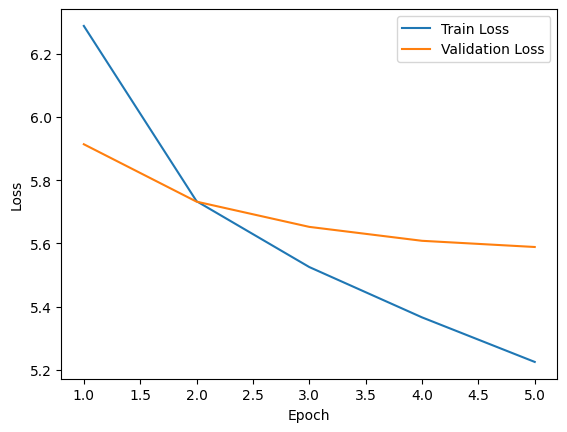

In [19]:
import matplotlib.pyplot as plt

epochs = [i + 1 for i in range(len(train_losses))]  # start from 1 instead of 0

plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

We can see that both curves are having a decreasing trend, where train loss has a faster decreasing rate than validation loss.

## D: Step 7: Evaluate the model

In [21]:
def cross_entropy_loss_and_perplexity(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x,y in data_loader:
            output, _ =model(x)
            loss = criterion(output.view(-1, vocab_size), y.view(-1))
            total_loss += loss.item()
    avg_loss =  total_loss/ len(data_loader)
    perplexity = np.exp(avg_loss)
    return avg_loss, perplexity

### Evaluation

In [22]:
val_loss, val_PPL = cross_entropy_loss_and_perplexity(model, val_loader)
test_loss, test_PPL = cross_entropy_loss_and_perplexity(model, test_loader)
print(f"Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}")
print(f"Val Perplexity: {val_PPL:.4f}, Test Perplexity: {test_PPL:.4f}")

Val Loss: 5.5886, Test Loss: 5.5818
Val Perplexity: 267.3636, Test Perplexity: 265.5416


Generalisation Ratio = 267.3636/265.5416 = 1.007

Observation made is that the test perplexity is slightly lower than the validation perplexity, indicating that the model is generalising very well and is not overfitting to the validation set. This is a highly desirable outcome and confirms that the model's performance is robust on unseen data.

## D: Step 8: Generate Text¶

In [23]:
def generate_text(model, start_seq, max_len=1000, temperature=1.0, max_words=None, top_k=None):
    model.eval()
    idx_seq = [vocab.get(word, vocab["<unk>"]) for word in start_seq]
    x = torch.tensor([idx_seq], dtype=torch.long)
    hidden = None
    result = start_seq.copy()

    for _ in range(max_len):
        output, hidden = model(x, hidden)
        logits = output[:, -1, :] / temperature

        # ---- Top-k filtering ----
        if top_k is not None:
            topk_logits, topk_indices = torch.topk(logits, top_k)
            probs = torch.softmax(topk_logits, dim=-1)
            next_token = topk_indices[torch.multinomial(probs, num_samples=1)].item()
        else:
            # Standard multinomial sampling (full vocab)
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1).item()
        # -------------------------

        # Only if want early stopping at <eos>
        # if next_token == vocab["<eos>"]:
        #     break

        result.append(inv_vocab[next_token])
        if max_words is not None and len(result) >= max_words:
            break

        x = torch.tensor([[next_token]], dtype=torch.long)

    return " ".join(result)

In [24]:
for T in [0.7, 1.0, 1.3]:
    print(f"[Sampling with T={T}] ")
    print(generate_text(model, ["the"], max_len=1000, max_words=150, temperature=T))
    

[Sampling with T=0.7] 
the basilisk appointed make her death and tragical her maid <eos> leaving her own eyes <eos> her and that she does not would have heard the game of the night and will worship <eos> these things to make me trust <eos> him <eos> <eos> those that he shall rise and find it out <eos> in the world and the old business as it is wise he is in me <eos> not <eos> the cup of her own <eos> that are you <eos> in such place <eos> the which he would not break out with your blood with with ordure and there be kept in my tongue <eos> an excellent and such humour as the sickness of her have no less than for what <eos> to this love <eos> <eos> left you <eos> you <eos> to <eos> the sudden of your spirits <eos> and the vantage of your grace he is
[Sampling with T=1.0] 
the le pleasure tender footing grammar thorn blush so every as his shames yet impudent at too much spirit <eos> and in such yorks that raught him pight thou quiet living in thy woes as swore would cost <eos> forth he p

# Section E: Ablation Study on Dropout = 0.0

## E: Steps 1-3 are the same

## E: Step 4: Build the LSTM Model

In [12]:
import torch.nn as nn

class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, pad_idx, dropout=0.0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)          # (batch, seq_len, embed_size)
        output, hidden = self.lstm(x, hidden)  # (batch, seq_len, hidden_size)
        logits = self.fc(output)       # (batch, seq_len, vocab_size)
        return logits, hidden

## E: Step 5: Build the model

In [13]:
# ----- Hyperparameters -----
vocab_size = len(vocab)
embed_size = 128
hidden_size = 256
num_layers = 1
dropout = 0.0
learning_rate = 1e-3
weight_decay = 1e-5
num_epochs = 5
grad_accum_steps = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- Initialize Model -----
model = LSTMLanguageModel(vocab_size, embed_size, hidden_size, num_layers, pad_idx=vocab["<pad>"], dropout=dropout).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=vocab["<pad>"])
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)

In [14]:
# ----- Tracking -----
train_losses, train_PPL, val_losses, val_PPL = [], [], [], []

def clip_gradients(model, max_norm=1.0):
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

In [15]:
# ----- Training Loop -----
import time
start_time = time.time()

for epoch in range(num_epochs):
    ## ----- Training -----
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for step, (x, y) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        x, y = x.to(device), y.to(device)
        output, _ = model(x)
        loss = criterion(output.view(-1, vocab_size), y.view(-1))

        # Gradient accumulation
        loss = loss / grad_accum_steps
        loss.backward()

        if (step + 1) % grad_accum_steps == 0:
            clip_gradients(model, max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item() * grad_accum_steps

    avg_train_loss = total_loss / len(train_loader)
    train_perplexity = np.exp(avg_train_loss)
    train_losses.append(avg_train_loss)
    train_PPL.append(train_perplexity)

    ## ----- Validation -----
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            output, _ = model(x)
            loss = criterion(output.view(-1, vocab_size), y.view(-1))
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_perplexity = np.exp(avg_val_loss)
    val_losses.append(avg_val_loss)
    val_PPL.append(val_perplexity)

    # Scheduler step
    scheduler.step(avg_val_loss)

    ## ----- Logs -----
    print(f"Epoch {epoch+1} | "
          f"Train Loss: {avg_train_loss:.4f} | Train PPL: {train_perplexity:.2f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val PPL: {val_perplexity:.2f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")

# ----- End time -----
end_time = time.time()
print(f"Total training time: {(end_time - start_time)/60:.2f} minutes")

Training Epoch 1: 100%|█████████████████████| 2618/2618 [26:47<00:00,  1.63it/s]


Epoch 1 | Train Loss: 6.2885 | Train PPL: 538.36 | Val Loss: 5.9151 | Val PPL: 370.60 | LR: 0.001000


Training Epoch 2: 100%|█████████████████████| 2618/2618 [27:01<00:00,  1.61it/s]


Epoch 2 | Train Loss: 5.7282 | Train PPL: 307.41 | Val Loss: 5.7328 | Val PPL: 308.84 | LR: 0.001000


Training Epoch 3: 100%|█████████████████████| 2618/2618 [26:34<00:00,  1.64it/s]


Epoch 3 | Train Loss: 5.5152 | Train PPL: 248.45 | Val Loss: 5.6489 | Val PPL: 283.97 | LR: 0.001000


Training Epoch 4: 100%|█████████████████████| 2618/2618 [26:48<00:00,  1.63it/s]


Epoch 4 | Train Loss: 5.3538 | Train PPL: 211.41 | Val Loss: 5.6102 | Val PPL: 273.20 | LR: 0.001000


Training Epoch 5: 100%|█████████████████████| 2618/2618 [27:56<00:00,  1.56it/s]


Epoch 5 | Train Loss: 5.2108 | Train PPL: 183.23 | Val Loss: 5.5949 | Val PPL: 269.06 | LR: 0.001000
Total training time: 141.80 minutes


In [16]:
# Create a table for all values

import pandas as pd
data = {
    "Train Loss": train_losses,
    "Train PPL": train_PPL,
    "Val Loss": val_losses,
    "Val PPL": val_PPL
}
# Build DataFrame
df = pd.DataFrame(data, index=[f"Epoch {i+1}" for i in range(num_epochs)])


# Add final row for training time
training_time_minutes = (end_time - start_time) / 60
df.loc[num_epochs] = [f"---", f"---", f"---", f"Time: {training_time_minutes:.2f} min"]

# Show table
print(df)

        Train Loss   Train PPL  Val Loss           Val PPL
Epoch 1   6.288534  538.363491  5.915125        370.600617
Epoch 2    5.72817  307.406092  5.732834        308.843197
Epoch 3   5.515228  248.446527  5.648884        283.974414
Epoch 4   5.353792  211.408525  5.610189         273.19584
Epoch 5   5.210768  183.234724  5.594926        269.057797
5              ---         ---       ---  Time: 141.80 min


Both the training loss and validation loss are consistently decreasing with each epoch, showing an excellent sign that the model is learning and that the training process is stable and effective.

## E: Step 6: Plot Training and Validation Loss curves

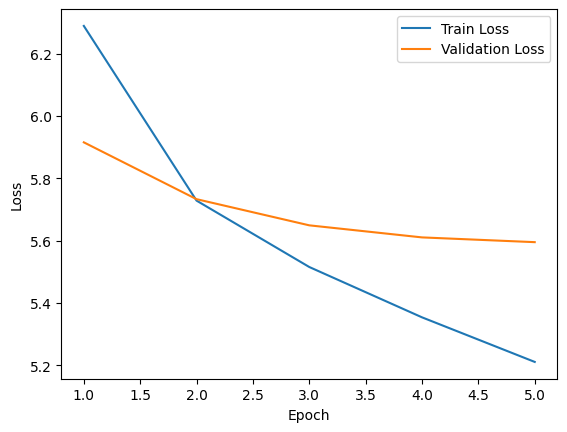

In [30]:
import matplotlib.pyplot as plt

epochs = [i + 1 for i in range(len(train_losses))] 

plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

We can see that both curves are having a decreasing trend, where train loss has a faster decreasing rate than validation loss.

## E: Step 7: Evaluate the model

In [19]:
def cross_entropy_loss_and_perplexity(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x,y in data_loader:
            output, _ =model(x)
            loss = criterion(output.view(-1, vocab_size), y.view(-1))
            total_loss += loss.item()
    avg_loss =  total_loss/ len(data_loader)
    perplexity = np.exp(avg_loss)
    return avg_loss, perplexity

In [20]:
val_loss, val_PPL = cross_entropy_loss_and_perplexity(model, val_loader)
test_loss, test_PPL = cross_entropy_loss_and_perplexity(model, test_loader)
print(f"Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}")
print(f"Val Perplexity: {val_PPL:.4f}, Test Perplexity: {test_PPL:.4f}")

Val Loss: 5.5949, Test Loss: 5.5873
Val Perplexity: 269.0578, Test Perplexity: 267.0170


Generalisation Ratio = 269.0578/267.0170 = 1.008

Observation made is that the test perplexity is slightly lower than the validation perplexity, and with the generalisation ratio close to 1, indicating that the model is generalising very well and is not overfitting to the validation set. This is a highly desirable outcome and confirms that the model's performance is robust on unseen data.

Overall, the LSTM base model still performed better than this ablation study of dropout 0.0 instead of 0.3, as the generalisation ratio is still closer to 1 than this model (original: 1.007, ablation: 1.008), and the validation and test perplexity (267.36 to 269.06 and 265.54 to 267.02, respectively) performed worse than the LSTM base model.

## E: Step 8: Generate Text

In [28]:
def generate_text(model, start_seq, max_len=1000, temperature=1.0, max_words=None, top_k=None):
    model.eval()
    idx_seq = [vocab.get(word, vocab["<unk>"]) for word in start_seq]
    x = torch.tensor([idx_seq], dtype=torch.long)
    hidden = None
    result = start_seq.copy()

    for _ in range(max_len):
        output, hidden = model(x, hidden)
        logits = output[:, -1, :] / temperature

        # ---- Top-k filtering ----
        if top_k is not None:
            topk_logits, topk_indices = torch.topk(logits, top_k)
            probs = torch.softmax(topk_logits, dim=-1)
            next_token = topk_indices[torch.multinomial(probs, num_samples=1)].item()
        else:
            # Standard multinomial sampling (full vocab)
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1).item()
        # -------------------------

        # Only if want early stopping at <eos>
        # if next_token == vocab["<eos>"]:
        #     break

        result.append(inv_vocab[next_token])
        if max_words is not None and len(result) >= max_words:
            break

        x = torch.tensor([[next_token]], dtype=torch.long)

    return " ".join(result)


In [29]:
for T in [0.7, 1.0, 1.3]:
    print(f"[Sampling with T={T}] ")
    print(generate_text(model, ["the"], max_len=1000, max_words=150, temperature=T))

[Sampling with T=0.7] 
the nick enchanting full of his thoughts which with his eyes lack for his power <eos> he had his head to th court and the the blow and sects of his own <eos> <eos> <eos> and to be the spoil of his valiant isle <eos> this dead and therefore with their own dear parts show be with his heart <eos> weep and he gave me in the door <eos> in the blossoms who believe the other and they are of their the steel <eos> many men <eos> the king <eos> the prince of gloucester <eos> and the very reverend that bound him from the streets of the time <eos> <eos> the dauphin <eos> and in the both of all faults <eos> and the gilt is not the cold throne <eos> <eos> by the morning <eos> for am looked to stretch the present that we run our claim <eos> <eos> with
[Sampling with T=1.0] 
the right poet called affied stop gratiano and heavenly is loves by being not permit twas bounds no more eye from death but man should demonstrate prey for whosoever enforced ten rings it heat near change hi

# Section F: Ablation Study on Sequence Length = 64

## F: Steps 1-2 are the same

## F: Step 3: Define Dataset and Dataloader

In [31]:
from torch.utils.data import Dataset, DataLoader
import torch

class ShakespheareLSTMDataset(Dataset):
    def __init__(self, data, pad_idx, max_len=64):
        """
        data: list of numericalized sentences (list of lists)
        pad_idx: index of <pad>
        max_len: maximum sequence length
        """
        self.data = data
        self.pad_idx = pad_idx
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx][:-1]   # input: all except last token
        y = self.data[idx][1:]    # target: all except first token

        # Pad or truncate
        x = x[:self.max_len] + [self.pad_idx] * max(0, self.max_len - len(x))
        y = y[:self.max_len] + [self.pad_idx] * max(0, self.max_len - len(y))

        return torch.tensor(x), torch.tensor(y)

In [32]:
pad_idx = vocab["<pad>"]
batch_size = 32
train_dataset = ShakespheareLSTMDataset(train_data, pad_idx)
val_dataset = ShakespheareLSTMDataset(val_data, pad_idx)
test_dataset = ShakespheareLSTMDataset(test_data, pad_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## F: Step 4: Create LSTM Model

In [33]:
import torch.nn as nn

class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, pad_idx, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)          # (batch, seq_len, embed_size)
        output, hidden = self.lstm(x, hidden)  # (batch, seq_len, hidden_size)
        logits = self.fc(output)       # (batch, seq_len, vocab_size)
        return logits, hidden

## F: Step 5: Build the model

In [34]:
# ----- Hyperparameters -----
vocab_size = len(vocab)
embed_size = 128
hidden_size = 256
num_layers = 1
dropout = 0.3
learning_rate = 1e-3
weight_decay = 1e-5
num_epochs = 5
grad_accum_steps = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- Initialize Model -----
model = LSTMLanguageModel(vocab_size, embed_size, hidden_size, num_layers, pad_idx=vocab["<pad>"], dropout=dropout).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=vocab["<pad>"])
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


In [35]:
# ----- Tracking -----
train_losses, train_PPL, val_losses, val_PPL = [], [], [], []

def clip_gradients(model, max_norm=1.0):
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

In [36]:
# ----- Training Loop -----
import time
start_time = time.time()

for epoch in range(num_epochs):
    ## ----- Training -----
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for step, (x, y) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        x, y = x.to(device), y.to(device)
        output, _ = model(x)
        loss = criterion(output.view(-1, vocab_size), y.view(-1))

        # Gradient accumulation
        loss = loss / grad_accum_steps
        loss.backward()

        if (step + 1) % grad_accum_steps == 0:
            clip_gradients(model, max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item() * grad_accum_steps

    avg_train_loss = total_loss / len(train_loader)
    train_perplexity = np.exp(avg_train_loss)
    train_losses.append(avg_train_loss)
    train_PPL.append(train_perplexity)

    ## ----- Validation -----
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            output, _ = model(x)
            loss = criterion(output.view(-1, vocab_size), y.view(-1))
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_perplexity = np.exp(avg_val_loss)
    val_losses.append(avg_val_loss)
    val_PPL.append(val_perplexity)

    # Scheduler step
    scheduler.step(avg_val_loss)

    ## ----- Logs -----
    print(f"Epoch {epoch+1} | "
          f"Train Loss: {avg_train_loss:.4f} | Train PPL: {train_perplexity:.2f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val PPL: {val_perplexity:.2f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")

# ----- End time -----
end_time = time.time()
print(f"Total training time: {(end_time - start_time)/60:.2f} minutes")

Training Epoch 1: 100%|█████████████████████| 2618/2618 [14:08<00:00,  3.09it/s]


Epoch 1 | Train Loss: 6.2829 | Train PPL: 535.33 | Val Loss: 5.9092 | Val PPL: 368.41 | LR: 0.001000


Training Epoch 2: 100%|█████████████████████| 2618/2618 [14:24<00:00,  3.03it/s]


Epoch 2 | Train Loss: 5.7215 | Train PPL: 305.38 | Val Loss: 5.7251 | Val PPL: 306.46 | LR: 0.001000


Training Epoch 3: 100%|█████████████████████| 2618/2618 [13:54<00:00,  3.14it/s]


Epoch 3 | Train Loss: 5.5033 | Train PPL: 245.50 | Val Loss: 5.6418 | Val PPL: 281.97 | LR: 0.001000


Training Epoch 4: 100%|█████████████████████| 2618/2618 [13:39<00:00,  3.19it/s]


Epoch 4 | Train Loss: 5.3402 | Train PPL: 208.55 | Val Loss: 5.5999 | Val PPL: 270.41 | LR: 0.001000


Training Epoch 5: 100%|█████████████████████| 2618/2618 [14:07<00:00,  3.09it/s]


Epoch 5 | Train Loss: 5.1947 | Train PPL: 180.32 | Val Loss: 5.5876 | Val PPL: 267.10 | LR: 0.001000
Total training time: 73.67 minutes


In [37]:
# Create a table for all values

#import pandas as pd
data = {
    "Train Loss": train_losses,
    "Train PPL": train_PPL,
    "Val Loss": val_losses,
    "Val PPL": val_PPL
}
# Build DataFrame
df = pd.DataFrame(data, index=[f"Epoch {i+1}" for i in range(num_epochs)])


# Add final row for training time
training_time_minutes = (end_time - start_time) / 60
df.loc[num_epochs] = [f"---", f"---", f"---", f"Time: {training_time_minutes:.2f} min"]

# Show table
print(df)

        Train Loss   Train PPL  Val Loss          Val PPL
Epoch 1   6.282876  535.325921   5.90919       368.407623
Epoch 2   5.721548  305.377314  5.725073       306.455655
Epoch 3   5.503282  245.496358  5.641816       281.974435
Epoch 4   5.340172  208.548494  5.599931       270.407652
Epoch 5   5.194722  180.318031  5.587625       267.100635
5              ---         ---       ---  Time: 73.67 min


Both the training loss and validation loss are consistently decreasing with each epoch, showing an excellent sign that the model is learning and that the training process is stable and effective.

## F: Step 6: Plot training and validation loss curves

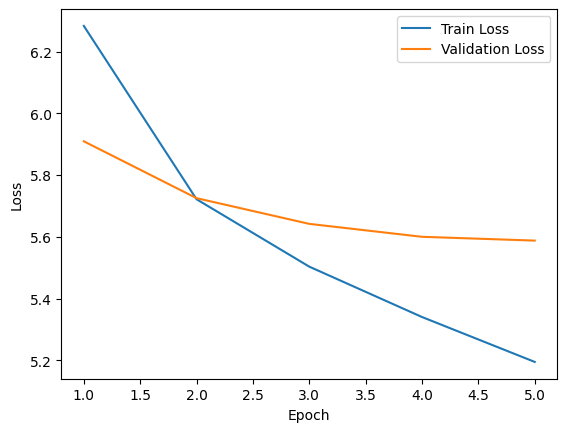

In [38]:
import matplotlib.pyplot as plt

epochs = [i + 1 for i in range(len(train_losses))]  # start from 1 instead of 0

plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

We can see that both curves are having a decreasing trend, where train loss has a faster decreasing rate than validation loss.

## F: Step 7: Evaluate the model

In [39]:
def cross_entropy_loss_and_perplexity(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x,y in data_loader:
            output, _ =model(x)
            loss = criterion(output.view(-1, vocab_size), y.view(-1))
            total_loss += loss.item()
    avg_loss =  total_loss/ len(data_loader)
    perplexity = np.exp(avg_loss)
    return avg_loss, perplexity

In [41]:
val_loss, val_PPL = cross_entropy_loss_and_perplexity(model, val_loader)
test_loss, test_PPL = cross_entropy_loss_and_perplexity(model, test_loader)
print(f"Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}")
print(f"Val Perplexity: {val_PPL:.4f}, Test Perplexity: {test_PPL:.4f}")

Val Loss: 5.5876, Test Loss: 5.5805
Val Perplexity: 267.1006, Test Perplexity: 265.1925


Generalisation Ratio = 267.1006/265.1925 = 1.007

Both perplexities are very low, and the fact that the test perplexity is slightly lower than the validation perplexity and the generalisation ratio is close to 1 means that the model is generalising exceptionally well and is not overfitting.

Overall, this model performed better than the LSTM base model of sequence length of 128 instead of 64, as the validation and test perplexity (267.36 to 267.10 and 265.54 to 265.19, respectively) performed better than the LSTM base model, while the generalisation ratio for both remained unchanged at 1.007.

## F: Step 8: Generate text

In [42]:
def generate_text(model, start_seq, max_len=1000, temperature=1.0, max_words=None, top_k=None):
    model.eval()
    idx_seq = [vocab.get(word, vocab["<unk>"]) for word in start_seq]
    x = torch.tensor([idx_seq], dtype=torch.long)
    hidden = None
    result = start_seq.copy()

    for _ in range(max_len):
        output, hidden = model(x, hidden)
        logits = output[:, -1, :] / temperature

        # ---- Top-k filtering ----
        if top_k is not None:
            topk_logits, topk_indices = torch.topk(logits, top_k)
            probs = torch.softmax(topk_logits, dim=-1)
            next_token = topk_indices[torch.multinomial(probs, num_samples=1)].item()
        else:
            # Standard multinomial sampling (full vocab)
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1).item()
        # -------------------------

        # Only if want early stopping at <eos>
        # if next_token == vocab["<eos>"]:
        #     break

        result.append(inv_vocab[next_token])
        if max_words is not None and len(result) >= max_words:
            break

        x = torch.tensor([[next_token]], dtype=torch.long)

    return " ".join(result)


In [43]:
for T in [0.7, 1.0, 1.3]:
    print(f"[Sampling with T={T}] ")
    print(generate_text(model, ["the"], max_len=1000, max_words=150, temperature=T))

[Sampling with T=0.7] 
the romano whose vantage over the other side of the world <eos> and their eyes were force and to the king let us <eos> <eos> the enobarbus <eos> that the best ne er to heaven and kiss the packet of his friends so long and our whole three cold friends <eos> heaven to the moon <eos> and the bottom of this an hour to be so <eos> <eos> and tremble with me <eos> <eos> and will you go <eos> <eos> the senators of your hell and you are gone <eos> and ere the cannons of the other time to the city <eos> <eos> the day <eos> and on this town and this parallel do if the day do be to this <eos> <eos> <eos> and take all our solemnity <eos> <eos> <eos> <eos> <eos> <eos> <eos> from him <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> with them <eos>
[Sampling with T=1.0] 
the scruples prospect cutlers gage god had these done thy money reform always my part took it not yet slaughter till leads him <eos> for the forest of your majesty were now surmount too mole till meet his s